In [1]:
from darts.models.forecasting.lgbm import LightGBMModel
from darts import TimeSeries

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/home/mahdi/anaconda3/envs/darts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
df = pd.read_csv('datasets/climate/temp_anom_w_forcing.csv')


In [3]:
df

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12
...,...,...,...,...,...,...,...,...,...,...,...
158,2008,3.366880,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.409630,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.450820,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.492780,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62


In [4]:
len(df)

163

In [5]:
corr_matrix = df.corr()

In [6]:
corr_matrix['Anomaly'].sort_values()

TropAerDir   -0.886840
TropAerInd   -0.865217
Land_Use     -0.702413
StratAer      0.099543
Solar         0.533798
Orbital       0.773553
SnowAlb_BC    0.778150
Year          0.787325
Ozone         0.881106
WMGHG         0.900849
Anomaly       1.000000
Name: Anomaly, dtype: float64

<Axes: >

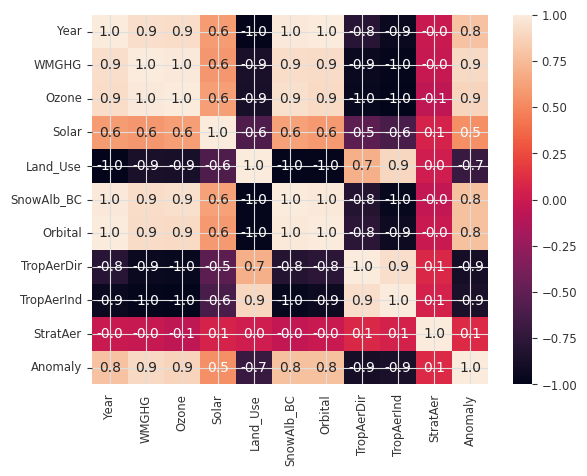

In [7]:
import seaborn as sns

sns.heatmap(corr_matrix, annot=True, fmt=".1f", vmax=1, vmin=-1)

In [8]:
#df = df[df['Year'] >= 1880]

<Axes: xlabel='Year'>

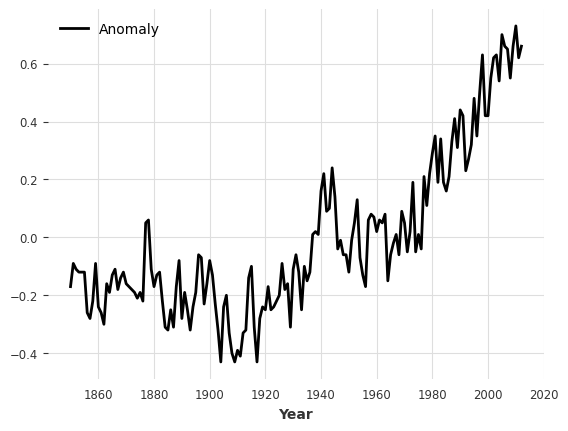

In [9]:
list_of_covariates = ['WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', \
                      'Orbital', 'TropAerDir', 'TropAerInd', 'StratAer']



target_series = TimeSeries.from_dataframe(df, 'Year', 'Anomaly')
past_covariates = TimeSeries.from_dataframe(df, 'Year', list_of_covariates)

target_series.plot()

In [10]:
from darts.utils.statistics import extract_trend_and_seasonality, check_seasonality, remove_trend
check_seasonality(target_series)

(False, 0)

In [11]:
#methods = [member for member in dir(target_series) if callable(getattr(target_series, member)) and not member.startswith("__")]

#for method in methods:
#    print(method)

In [12]:
#past_covariates.plot()

In [13]:
num_test = 24
target_series_train, target_series_test = target_series[:-num_test], target_series[-num_test:]
past_covariates_train, past_covariates_test = past_covariates[:-num_test], past_covariates[-num_test:]




In [14]:
def test():
    print('MTR')

In [15]:
#output_chunk_length = int(num_test/8)
#n_lags = num_test*2
output_chunk_length = 1
n_lags = output_chunk_length*7

#model = LightGBMModel(lags=n_lags, output_chunk_length=num_test, \
#                      lags_past_covariates=[-n_lags]*past_covariates.n_components)

model = LightGBMModel(lags=n_lags, lags_past_covariates=n_lags, output_chunk_length=output_chunk_length, \
                      max_depth=-1, learning_rate=0.1, n_estimators=100, num_leaves=31, \
                      is_training_metric=True, verbose=10, reg_lambda=0.1)

In [16]:
eval_result = {}
from lightgbm import record_evaluation

model.fit(target_series_train, 
          past_covariates=past_covariates_train, \
          val_series=[target_series_train, target_series_test],
          callbacks=[record_evaluation(eval_result)])

/home/mahdi/anaconda3/envs/darts/lib/python3.10/site-packages/darts/utils/data/tabularization.py:1293: UserWarning: `lags_past_covariates` was specified without accompanying `past_covariates` and, thus, will be ignored.
  warnings.warn(
/home/mahdi/anaconda3/envs/darts/lib/python3.10/site-packages/lightgbm/basic.py:295: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000974
[LightGBM] [Debug] init for col-wise cost 0.000012 seconds, init for row-wise cost 0.000289 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2882
[LightGBM] [Info] Number of data points in the train set: 132, number of used features: 70
[LightGBM] [Info] Start training from score -0.095909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, bes

LightGBMModel(lags=7, lags_past_covariates=7, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None, max_depth=-1, learning_rate=0.1, n_estimators=100, num_leaves=31, is_training_metric=True, verbose=10)

In [17]:
eval_result.keys()

dict_keys(['valid_0'])

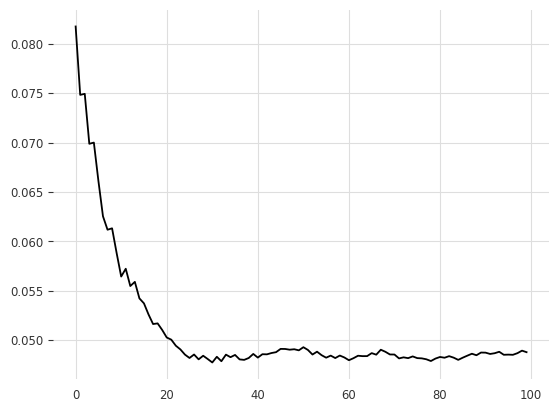

In [18]:
import matplotlib.pyplot as plt
plt.plot(eval_result['valid_0']['l2'])

### Training Curve

In [19]:
class_attributes = [attr for attr in dir(model) if not callable(getattr(model, attr)) and not attr.startswith("__") and not attr.startswith("_")]

In [20]:
num_test

24

In [21]:
#target_series_test_pred = model.predict(num_test*2, series=target_series_train)
target_series_test_pred = model.predict(num_test, series=target_series_train, past_covariates=past_covariates)

In [22]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(target_series_train)
naive_forecast = naive_model.predict(num_test)

In [23]:
target_series_train_hist_forecast = model.historical_forecasts(target_series_train, retrain=False)

<Axes: xlabel='time'>

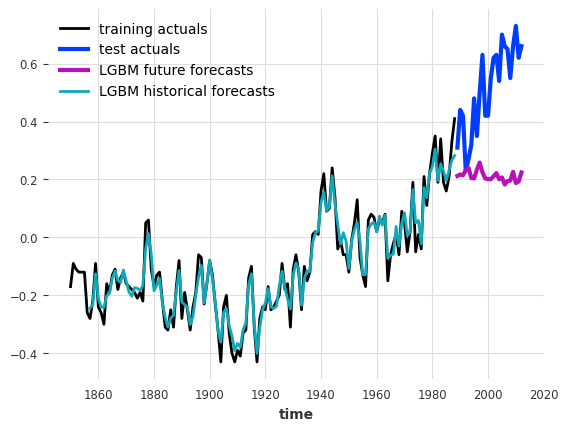

In [24]:
target_series_train.plot(label='training actuals')
target_series_test.plot(label='test actuals', lw=3)
target_series_test_pred.plot(label='LGBM future forecasts', lw=3)
target_series_train_hist_forecast.plot(label='LGBM historical forecasts')
#model.training_series.plot(label='model.training_series')

In [ ]:
len(df)